# 多类分类
使用逻辑回归和神经网络来识别手写数字

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.io import loadmat
from sklearn.metrics import classification_report

### 数据集
ex3data2.mat文件里面有5000个训练样例，每一个训练样例都是一个数字的$20\times20$（像素）的灰度图像。用浮点数来表示一个像素，数值大小表示所在位置的灰度强度。  
<b>矩阵$X$</b>：每$20\times20$的像素网格会被展开成一个400维的向量，然后成为矩阵$X$里面的一行，即矩阵$X$里面的一行代表一个训练样例。所以矩阵$X$的维度为$5000\times400$。  
<b>向量$y$</b>：包含对应训练样例的训练标签，注意，0被标为10，1-9还是被标为1-9。向量$y$的维度为5000。

In [2]:
data = loadmat('ex3data1.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

### 可视化数据
随机选择100张图，绘制出来。

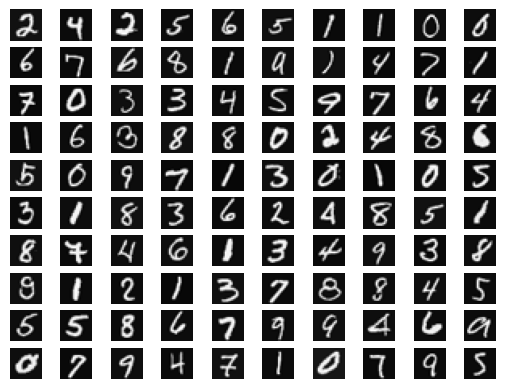

In [3]:
row_rand_array = np.arange(data['X'].shape[0])
np.random.shuffle(row_rand_array)
sel_rows = data['X'][row_rand_array[0:100]]

fig ,axes = plt.subplots(10, 10)
for i in range(10):
    for j in range(10):
        idx = i * 10 + j
        a = sel_rows[idx]
        a.shape = 20, 20
        axes[i][j].imshow(a.T, cmap = 'gray')
        axes[i][j].axis('off')
plt.show()

### 向量化逻辑回归
使用多个一对多逻辑回归模型来构建多类分类器。在这次作业中，需要训练10个独立的逻辑回归分类器。实现逻辑回归的向量化版本，不要使用循环。

向量化代价函数：

In [4]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [5]:
def cost(theta, X, y):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    h = sigmoid(X * theta.T)
    first = np.multiply(- y, np.log(h))
    second = np.multiply((1 - y), np.log(1 - h))
    J = np.mean(first - second) 
    return J

向量化梯度函数：
<img src="gradient.jpg" width = 300>

In [6]:
def gradient(theta, X, y):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    para_nums = np.size(theta)
    h = sigmoid(X * theta.T)
    error = h - y
    
    grad = X.T * error / len(X)
    return np.array(grad).flatten() # gradient must have shape (len(x0),)，即需要将矩阵/多维数组降为一维

向量化正则化逻辑回归：

In [7]:
def costReg(theta, X, y, Lambda):
    X = np.matrix(X)
    theta = np.matrix(theta)
    
    reg = (Lambda / (2 * len(X))) * np.sum(np.power(theta[:, 1:], 2))
    return cost(theta, X, y) + reg

In [8]:
def gradientReg(theta, X, y, Lambda):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    para_nums = np.size(theta)
    h = sigmoid(X * theta.T)
    error = h - y
    
    reg = (Lambda / len(X)) * theta.T
    reg[0] = 0
    grad = X.T * error / len(X) + reg
    
    return np.array(grad).flatten() # gradient must have shape (len(x0),)，即需要将矩阵/多维数组降为一维

### One-vs-all Classification

In [9]:
def one_vs_all(X, y, Lambda, K):# K为标签个数
    n = X.shape[1]
    # 每个分类器都对应一个theta向量，有K个分类器
    theta_all = np.zeros((K, n))
    
    # 为每个分类器寻找最优参数theta，注意：0被标为10，1-9被标为1-9
    for i in range(1, K + 1):
        theta_i = np.zeros(n)
        y_i = np.array([1 if label == i else 0 for label in y])
        y_i.shape = y_i.shape[0],1
        result = opt.minimize(fun = costReg,
                              x0 = theta_i,
                              args = (X, y_i, Lambda),
                              method = 'TNC',
                              jac = gradientReg)
        theta_all[i - 1, :] = result.x
        
    return theta_all

训练分类器:

In [10]:
X = np.insert(data['X'], 0, values = 1, axis = 1)
y = data['y']

In [11]:
Lambda = 1
K = 10

theta_all = one_vs_all(X, y, Lambda, K)
theta_all

array([[-2.38348193e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.30434214e-03, -7.35065572e-10,  0.00000000e+00],
       [-3.18367707e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.46390901e-03, -5.08945374e-04,  0.00000000e+00],
       [-4.79714546e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.87516886e-05, -2.47692361e-07,  0.00000000e+00],
       ...,
       [-7.98792376e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -8.95328541e-05,  7.21727348e-06,  0.00000000e+00],
       [-4.57269037e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.33600877e-03,  9.99228175e-05,  0.00000000e+00],
       [-5.40479190e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.16679180e-04,  7.88926256e-06,  0.00000000e+00]])

使用训练好的one-vs-all分类器来预测所给图像上的数字。  
预测函数：对每个输入，都使用被训练好的逻辑回归分类器来计算它属于每个类的概率，然后选择概率最高的类，返回其标签。

In [12]:
def predict(X, theta):
    h = sigmoid(X @ theta.T)
    
   # 每个样本取自己10个预测中最大的值作为最终预测值
    h_argmax = np.argmax(h, axis = 1) #返回最大值的索引

    return h_argmax + 1

In [13]:
y_pre = predict(X, theta_all)
acc = np.mean(y_pre == y.flatten())
print("acc = {}%".format(acc * 100))

acc = 94.46%


### 神经网络

题目和数据集不变，但是直接给出了神经网络的训练参数结果，所以本练习只需要实现前向传播算法,使用这些参数进行预测即可。
下图是对应的神经网络模型：
<img src = "NNM.JPG" width = 280>
ex3weights.mat文件里提供了已经被训练好的一组网络参数($\Theta^{(1)},\Theta^{(2)}$) 。 
第二层的神经元数量为25。输入层的神经元数量为400，输出层的神经元的数量为10。

In [14]:
def forward(raw_X, theta1, theta2):
    a1 = np.insert(raw_X, 0, values = 1, axis = 1)
    
    z2 = theta1 @ a1.T
    a2 = sigmoid(z2)
    a2 = np.insert(a2, 0, values = 1, axis = 0)
    
    z3 = theta2 @ a2
    a3  =sigmoid(z3) # 输出
    
    h_argmax = np.argmax(a3, axis = 0)
    
    return h_argmax + 1

In [15]:
theta = loadmat('ex3weights.mat')
y_pre = forward(data['X'], theta['Theta1'], theta['Theta2'])
acc = np.mean(y_pre == y.flatten())
print("acc = {}%".format(acc * 100))

acc = 97.52%
